# Image caption generation using mxnet

This tutorial explains the steps involved in writing mxnet code for image caption generation. The main goal for image caption is to produce a caption given an image. For e.g., 

<p style="text-align: center;"> ![Image of Surfer](https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/testimage.jpg) </p> 

A possible caption for this image can be **Surfer in the ocean riding a large wave**

We would use a basic image caption model by implementing the [**Show and Tell: A Neural Image Caption Generator,  Vinyals et al., 2015**](https://arxiv.org/abs/1411.4555). The network model is shown below:

<p style="text-align: center;"> ![Network](https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/networkcaption.png) </p> 

The model uses an [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) network that takes as input the image feature vector (the output of last layer before the fully connected layer - see [http://josephkj.in/wp-content/uploads/2017/01/Classifier.html](http://josephkj.in/wp-content/uploads/2017/01/Classifier.html)). The caption associated with the image is fed as input to LSTM network after passing it through an embedding layer that converts the indices to a 2048 feature vector (same dimension as the image feature vector). The output is an one-hot encoding of the word indices. The LSTM's first input is a special start word < S > and the output word at time *t* is the same as the input word at time *t+1*. The sentence has a special stop word < /S > at the end. 

For training, we would use [MSCOCO](http://mscoco.org/dataset/#overview) dataset. The dataset contains a set of images each with upto 5 different captions. The network inputs, viz., feature vector for image, word indices and one-hot labels, are extracted/generated for a subset of the images and kept at [caption data pickle file](https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/captiondata10k.pickle). In particular, the pickle file contains the following for each element: feature vector (1x2048) and the corresponding caption as a set of indexes. It also contains the vocabulary index and the reverse index. 


In [17]:
import pickle
from mxnet.test_utils import download

pickle_file_url = "https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/captiondata10k.pickle"
download(pickle_file_url,overwrite=True)
pickle_file_url = "https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/captiondataval10k.pickle"
download(pickle_file_url,overwrite=True)

[allwords, allindexes, vocabwords, vocabids, _] = pickle.load(open('captiondata10k.pickle', 'r'))

In [18]:
key = allwords.keys()[0]
print 'feature vector: ', allwords[key][0]
print 'caption indexes: ', allwords[key][1]
print 'imgid: ', allindexes[key]
key = vocabwords.keys()[0]
print 'word -> index: ', key, '->', vocabwords[key]
key = vocabids.keys()[0]
print 'index -> word: ', key, '->', vocabids[key]

feature vector:  [[ 0.23896003  0.          0.92439228 ...,  0.42736265  0.50471681
   1.50801563]]
caption indexes:  [1, 19, 1019, 7, 14, 133, 490, 81, 211, 3, 2]
imgid:  262145
word -> index:  raining -> 3200
index -> word:  0 -> a


In [ ]:
## This module defines an LSTM cell

In [ ]:
'''
module that defines lstm network that is used for image captioning
'''
from collections import namedtuple

import mxnet as mx

LSTMState = namedtuple("LSTMState", ["c", "h"])
LSTMParam = namedtuple("LSTMParam", ["i2h_weight", "i2h_bias",
                                     "h2h_weight", "h2h_bias"])
LSTMModel = namedtuple("LSTMModel", ["rnn_exec", "symbol",
                                     "init_states", "last_states",
                                     "forward_state", "backward_state",
                                     "seq_data", "seq_labels", "seq_outputs",
                                     "param_blocks"])


def lstmcell(num_hidden, indata, prev_state, param, seqidx, layeridx):
    '''
    Defines an LSTM cell
    Args:
        num_hidden: number of hidden units
        indata: input data to LSTM cell
        prev_state: previous state vector
        param: parameter for this LSTM (weights and biases)
        seqidx: sequence id
        layeridx: layer index (0 - first layer, 1 - second layer). Useful for
        bi-directional LSTM
    Returns:
        LSTM cell object
    '''
    dropout = 0.3
    indata = mx.sym.Dropout(data=indata, p=dropout)
    i2h = mx.sym.FullyConnected(data=indata,
                                weight=param.i2h_weight,
                                bias=param.i2h_bias,
                                num_hidden=num_hidden * 4,
                                name="t%d_l%d_i2h" % (seqidx, layeridx))
    h2h = mx.sym.FullyConnected(data=prev_state.h,
                                weight=param.h2h_weight,
                                bias=param.h2h_bias,
                                num_hidden=num_hidden * 4,
                                name="t%d_l%d_h2h" % (seqidx, layeridx))
    gates = i2h + h2h
    slice_gates = mx.sym.SliceChannel(gates, num_outputs=4,
                                      name="t%d_l%d_slice" %
                                      (seqidx, layeridx))
    in_gate = mx.sym.Activation(slice_gates[0], act_type="sigmoid")
    in_transform = mx.sym.Activation(slice_gates[1], act_type="tanh")
    forget_gate = mx.sym.Activation(slice_gates[2], act_type="sigmoid")
    out_gate = mx.sym.Activation(slice_gates[3], act_type="sigmoid")
    next_c = (forget_gate * prev_state.c) + (in_gate * in_transform)
    next_h = out_gate * next_c

    return LSTMState(c=next_c, h=next_h)

In [ ]:
## This module builds the network for image captioning

In [19]:
def build_lstm_network(seq_len, input_size, num_hidden, num_embed, num_label,
                       prediction=False):
    '''
    Build the LSTM network
    Args:
        seq_len: length of the sequence - number of times to unroll
        input_size: input vector dimension
        num_hidden: number of hiddent units
        num_embed: output dimension for the embedding unit
        num_label: output dimension for the fully-connected unit
        prediction: True if used for prediction, False if for training
    Returns:
        LSTM network symbol
    '''
    embed_weight = mx.sym.Variable("embed_weight")
    cls_weight = mx.sym.Variable("cls_weight")
    cls_bias = mx.sym.Variable("cls_bias")

    # input image feature vector
    data = mx.sym.Variable('data')
    # word indices
    label = mx.sym.Variable('softmax_label')
    # one-hot encoding of word indices
    veclabel = mx.sym.Variable('veclabel')

    name = 'l0'
    param = LSTMParam(i2h_weight=mx.sym.Variable(name+"_i2h_weight"),
                      i2h_bias=mx.sym.Variable(name+"_i2h_bias"),
                      h2h_weight=mx.sym.Variable(name+"_h2h_weight"),
                      h2h_bias=mx.sym.Variable(name+"_h2h_bias"))
    lstm_state = LSTMState(c=mx.sym.Variable(name+"_init_c"),
                           h=mx.sym.Variable(name+"_init_h"))
    allsm = []
    # label indices
    labelidx = mx.sym.SliceChannel(data=label, num_outputs=seq_len,
                                   squeeze_axis=1)
    # label one-hot vector
    labelvec = mx.sym.SliceChannel(data=veclabel, num_outputs=seq_len,
                                   squeeze_axis=1)
    output = ''
    targetlen = seq_len
    if prediction:
        # increase seq_len to generate till stop words during testing
        # it is a hack for now
        targetlen = seq_len + 10
    for seqidx in range(targetlen):
        k = seqidx
        # testing may use more than seq_len, hence reuse the last input
        # as dummy labels for softmax
        if k >= seq_len:
            k = seq_len - 1
        # first iteration use image feature as input
        if k == 0:
            hidden = data
        else:
            # if in prediction mode and not in first iteration use the
            # system output generated in previous timestep as input
            if prediction & (k > 1):
                embed = mx.sym.Embedding(data=output,
                                         input_dim=input_size,
                                         weight=embed_weight,
                                         output_dim=num_embed, name='embed')
            else:
                embed = mx.sym.Embedding(data=labelvec[k-1],
                                         input_dim=input_size,
                                         weight=embed_weight,
                                         output_dim=num_embed, name='embed')
            hidden = embed

        next_state = lstmcell(num_hidden, indata=hidden,
                              prev_state=lstm_state,
                              param=param, seqidx=k, layeridx=0)
        hidden = next_state.h
        lstm_state = next_state
        if k == 0:
            continue
        pred = mx.sym.FullyConnected(data=hidden, num_hidden=num_label,
                                     weight=cls_weight,
                                     bias=cls_bias, name='pred')
        softmax_output = mx.sym.SoftmaxOutput(data=pred, label=labelidx[k],
                                              name='softmax')
        output = mx.sym.argmax(softmax_output, axis=1)
        allsm.append(softmax_output)

    allsm = mx.sym.Concat(*allsm, dim=1)  # pylint: disable=star-args
    softmax_output = mx.sym.reshape(allsm, shape=(-1, num_label))
    return (softmax_output,
            ['veclabel', 'l0_init_h', 'l0_init_c', 'data'],
            ['softmax_label'])

## Building a bucket data iterator

Let us first built a bucket iterator to iterate over training samples. The function *default_gen_buckets* will generate a list of buckets based on the set of captions in the input

In [4]:
'''
module that defines bucketing data iter
'''
import mxnet as mx
import numpy as np
from mxnet.io import DataBatch
import pickle

def default_gen_buckets(allwords, batch_size):
    '''
    Generate buckets based on data. This method generates a list of buckets
    and the length of those buckets based on the input
    Args:
        allwords: all the sentences (set of words) that are part of the data
        batch_size: batch size to check if a particular bucket has that many
        elements
    Returns:
        returns the generated buckets
    '''
    len_dict = {}
    max_len = -1
    for key in allwords:
        words = allwords[key][1]
        if len(words) == 0:
            continue
        if len(words) > max_len:
            max_len = len(words)
        if len(words) in len_dict:
            len_dict[len(words)] += 1
        else:
            len_dict[len(words)] = 1
    buckets = []
    for length, num in len_dict.items():
        if num >= batch_size:
            buckets.append(length)

    return buckets

In [ ]:
## Main bucket iterator

In [11]:
class BucketIter(mx.io.DataIter):
    '''
    Class that defines the data iter for image captioning module
    '''
    def __init__(self, captionf, vocabf, featuref, batch_size=1):
        '''
        Init function for the class
        Args:
            captionf: pickle filename that has all the captions
            vocabf: pickle filename that has the vocabulary words
            featuref: feature filename that has feature vector for each
            image in the dataset
            batch_size: batch size for training data
        '''
        super(BucketIter, self).__init__()
        self.batch_size = batch_size

        # load datafiles
        [self.allwords, self.allindexes, self.vocabwords, self.vocabids, \
         self.unknown_id] = pickle.load(open(captionf, 'r'))

        # generate buckets
        buckets = default_gen_buckets(self.allwords, batch_size)
        buckets.sort()
        self.buckets = buckets
        # assing default bucket - ideally should be the largest bucket
        self.default_bucket_key = max(buckets)

        # Assign data to their corresponding bucket
        self.databkt = [[] for _ in buckets]
        self.cursor = {}
        self.num_data_bkt = {}
        for idx in self.allwords:
            strs = self.allwords[idx][1]
            for i, bkt in enumerate(buckets):
                if bkt == len(strs):
                    self.databkt[i].append(idx)
                    break
        
        # initialize bucket specific parameters, the current index into 
        # the bucket and the remaining number of elements in the bucket
        for i, bkt in enumerate(buckets):
            self.cursor[i] = -1
            self.num_data_bkt[i] = len(self.databkt[i])

    # iterator variables
        self.epoch = 0
        self.bidx = np.argmax(buckets)
        self.data, self.label, _ = self.read(self.bidx)
        self.reset()

    @property
    def bucket_key(self):
        '''
        bucket key for bucketiter module
        '''
        return self.buckets[self.bidx]

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(self.data[k].shape[0:]))) for k in self.data]
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(self.label[k].shape[0:]))) for k in self.label]
        return res

    def reset(self):
        '''
        data iter reset
        '''
        for index, _ in enumerate(self.cursor):
            self.cursor[index] = -1
        self.epoch += 1

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            # select one random bucket out of all the ones that has
            # > batch_size remaining samples
            rem = [i for i, _ in enumerate(self.buckets)
                   if (len(self.databkt[i])-self.cursor[i]) > self.batch_size]
            bidx = np.random.randint(0, len(rem))
            bidx = rem[bidx]
            # read the samples from the bucket
            self.data, self.label, imgids = self.read(bidx)
            # prepare as databatch to return
            res = DataBatch(provide_data=self.provide_data,
                            provide_label=self.provide_label,
                            bucket_key=self.buckets[self.bidx],
                            data=[mx.nd.array(self.data['veclabel']),
                                  mx.nd.array(self.data['l0_init_h']),
                                  mx.nd.array(self.data['l0_init_c']),
                                  mx.nd.array(self.data['data'])],
                            label=[mx.nd.array(self.label['softmax_label'])],
                            pad=0, index=None)
            #return res, imgids
            return res
        else:
            raise StopIteration

    def iter_next(self):
        '''
        check if next iteration can be done
        '''
        for i, _ in enumerate(self.buckets):
            if self.cursor[i] + self.batch_size < self.num_data_bkt[i]:
                return True
        return False

    def read(self, bidx):
        '''
        read the next set of data based on bucket index
        Args:
            bidx: bucket index
        '''
        self.bidx = bidx
        data_array = []
        allimgids = []
        label = []
        labelvec = []
        index = 0
        while 1:
            self.cursor[bidx] += 1
            data = self.get_data(bidx)
            imgid = self.get_imgids(bidx)
            labels = self.get_label(bidx)
            if len(labels) == 0:
                continue
            data_array.append(data)
            allimgids.append(imgid)
            labela = []
            labelveca = []
            for labelidx in labels:
                labelarray = np.zeros((len(self.vocabwords)+1), dtype='int')
                labelarray[labelidx] = 1
                labela.append(labelarray)
                labelveca.append(labelidx)
            label.append(labela)
            labelvec.append(labelveca)
            index += 1
            if index > (self.batch_size-1):
                break

        darray = np.vstack(data_array)
        imgidarray = np.vstack(allimgids)
        # this is also defined in trainmodel.py - need to consolidate
        num_hidden = 512

        data = {}
        data['l0_init_h'] = np.zeros((darray.shape[0], num_hidden),
                                     dtype='float')
        data['l0_init_c'] = np.zeros((darray.shape[0], num_hidden),
                                     dtype='float')
        data['data'] = darray
        data['veclabel'] = np.array(labelvec)

        finallabel = {}
        finallabel['softmax_label'] = np.asarray(label)

        return (data, finallabel, imgidarray)

    def get_data(self, bidx):
        '''
        Returns the feature vector based on the current cursor
        and bucket index
        Args:
            bidx: bucket index
        '''
        idx = self.databkt[bidx][self.cursor[bidx]]
        return self.allwords[idx][0]

    def get_imgids(self, bidx):
        '''
        Returns the feature vector based on the current cursor
        and bucket index
        Args:
            bidx: bucket index
        '''
        idx = self.databkt[bidx][self.cursor[bidx]]
        return self.allindexes[idx]

    def get_label(self, bidx):
        '''
        Returns the label vector based on the current cursor
        and bucket index
        Args:
            bidx: bucket index
        '''
        idx = self.databkt[bidx][self.cursor[bidx]]
        return self.allwords[idx][1]


In [12]:
'''
main code for training image captioning model
'''
import numpy as np
import logging

import mxnet as mx

DEBUG = True

In [13]:
def custommetric(label, pred):
    '''
    Simple metric that outputs the fraction of correct word predictions
    to the total number of words
    Args:
        label: ground truth label
        pred: predicted output
    Returns:
        accuracy metric
    '''
    # shift by one word to match prediction
    label = label[:, 1:, :]

    pred = np.reshape(pred, label.shape)
    label = np.argmax(label, axis=2)
    pred = np.argmax(pred, axis=2)
    return float(np.sum(pred == label))/np.sum(label >= 0)

In [21]:
BATCH_SIZE = 200
NUM_HIDDEN = 512
NUM_EPOCH = 300
GENERATE_GRAPH = False
DATADIR = '.'

# pylint: disable=C0103
data_train = BucketIter(DATADIR+'/captiondata10k.pickle',
                                     DATADIR+'/vocab.pickle',
                                     DATADIR+'/features.pickle',
                                     batch_size=BATCH_SIZE)
if DEBUG:
    print 'training data loaded ....'
    print data_train.provide_data, data_train.provide_label

INPUT_SIZE = data_train.provide_data[3][1][1]
NUM_LABEL = len(data_train.vocabwords)+1
if DEBUG:
    print INPUT_SIZE, NUM_LABEL

data_val = BucketIter(DATADIR+'/captiondataval10k.pickle',
                                   DATADIR+'/vocab.pickle',
                                   DATADIR+'/featuresval.pickle',
                                   batch_size=BATCH_SIZE)
if DEBUG:
    print 'validation data loaded ....'


training data loaded ....
[('veclabel', (200, 16)), ('l0_init_h', (200, 512)), ('l0_init_c', (200, 512)), ('data', (200, 2048))] [('softmax_label', (200, 16, 9955))]
2048 9955
validation data loaded ....


In [22]:
contexts = [mx.context.gpu(i) for i in range(1)]

# this is needed for the bucketing module
def sym_gen(seq_len):
    '''
    needed for bucketing module, network generated based on seq_len
    Args:
        seq_len: length of the current sequence
    Returns:
        Symbolic network
    '''
    return build_lstm_network(seq_len, INPUT_SIZE, NUM_HIDDEN, INPUT_SIZE,
                              NUM_LABEL)
model = mx.mod.BucketingModule(sym_gen, data_train.default_bucket_key,
                               context=contexts)

model.bind(data_shapes=data_train.provide_data,
           label_shapes=data_train.provide_label)
model.init_params(initializer=mx.init.Normal(sigma=0.01))

head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

In [ ]:
model.fit(data_train, data_val, num_epoch=NUM_EPOCH, optimizer='adam',
              optimizer_params={'learning_rate': 0.001},
              eval_metric=mx.metric.CustomMetric(custommetric),
              epoch_end_callback=mx.callback.do_checkpoint("imagecaption"))

## Test the model to generate a caption

In [24]:
'''
module that generates features for images using resnet
'''
import numpy as np
import os
import urllib
import cv2
import mxnet as mx
from collections import namedtuple

Batch = namedtuple('Batch', ['data'])


def download(url):
    '''
    download the file given the url
    Args:
        url: path for the filename
    '''
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)


def get_model(prefix, epoch):
    '''
    get the model with prefix and epoch
    Args:
        prefix: model prefix
        epoch: trained model - epoch
    '''
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))


def get_image(filename):
    '''
    return the image based on filename after resizing it to 224x224 to be
    fit for reset format
    Args:
        filename: filename of the image
    '''
    img = cv2.imread(filename)  # read image in b,g,r order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # change to r,g,b order
    img = cv2.resize(img, (224, 224))  # resize to 224*224 to fit model
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)  # change to (channel, height, width)
    img = img[np.newaxis, :]  # extend to (example, channel, heigth, width)
    return img


class Resnet(object):
    '''
    Resnet class to construct reset model object
    '''
    def __init__(self):
        '''
        Download the model from mxnet database and constructs the network
        for prediction
        '''
        url = 'http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50'
        get_model(url, 0)
        sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)
        all_layers = sym.get_internals()
        sym3 = all_layers['flatten0_output']
        mod3 = mx.mod.Module(symbol=sym3, label_names=None, context=mx.cpu())
        mod3.bind(for_training=False, data_shapes=[('data', (1, 3, 224, 224))])
        mod3.set_params(arg_params, aux_params)
        self.mod3 = mod3

    def gen_features(self, img_path):
        '''
        generate features given an image
        Args:
            img_path: full path to the image
        '''
        img = get_image(img_path)
        self.mod3.forward(Batch([mx.nd.array(img)]))
        return self.mod3.get_outputs()[0].asnumpy()


def get_feature(imgfname):
    '''
    Returns the feature for the image
    Args:
        imagefname: full path to the image
    '''
    network = Resnet()
    return network.gen_features(imgfname)

a man riding a surfboard on top of a wave . 


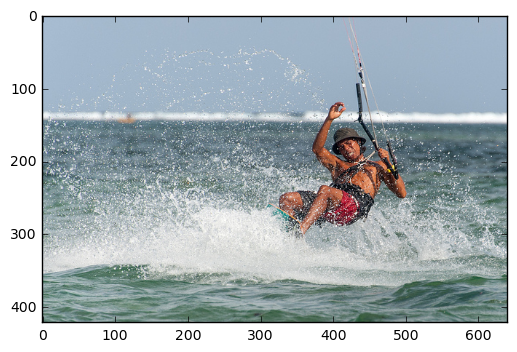

In [25]:
'''
generate captions for an image
'''
import numpy as np
import sys
import mxnet as mx
import pickle
import cv2
import matplotlib.pyplot as plt

# pylint: disable=star-args

%matplotlib inline
NUM_LSTM_LAYER = 1
BATCH_SIZE = 1
# pylint: disable=C0103

from mxnet.test_utils import download

img_url = "https://s3.amazonaws.com/gurumurthys-mxnet-data/data_image_caption/testimage.jpg"
download(img_url,overwrite=True)
imgfname = "testimage.jpg"

SEQ_LEN = 25

sym, arg_params, aux_params = \
    mx.model.load_checkpoint("imagecaption", 290)

NUM_HIDDEN = arg_params['l0_h2h_weight'].shape[1]
INPUT_SIZE = arg_params['l0_h2h_weight'].shape[0]
NUM_LABEL = arg_params['cls_weight'].shape[0]
sym, _, _ = build_lstm_network(SEQ_LEN, INPUT_SIZE, NUM_HIDDEN,
                               INPUT_SIZE, NUM_LABEL, prediction=True)

init_c = [('l%d_init_c' % l, (BATCH_SIZE, NUM_HIDDEN))
          for l in range(NUM_LSTM_LAYER)]
init_h = [('l%d_init_h' % l, (BATCH_SIZE, NUM_HIDDEN))
          for l in range(NUM_LSTM_LAYER)]
data_shape = [("data", (BATCH_SIZE, 2048))]
label_shape = [("veclabel",
                (BATCH_SIZE, SEQ_LEN, ))]
label_shape1 = [("softmax_label",
                 (BATCH_SIZE, SEQ_LEN, NUM_LABEL))]

f = get_feature(imgfname)
input_data = mx.nd.array(f)

veclabel = mx.nd.zeros((BATCH_SIZE, SEQ_LEN))
veclabel[0][0] = 0
input_shapes = dict(init_c+init_h+data_shape+label_shape+label_shape1)

executor = sym.simple_bind(ctx=mx.gpu(), **input_shapes)

for key in executor.arg_dict.keys():
    if key in arg_params:
        arg_params[key].copyto(executor.arg_dict[key])

state_name = []
for i in range(NUM_LSTM_LAYER):
    state_name.append("l%d_init_c" % i)
states_dict = dict(zip(state_name, executor.outputs[1:]))
input_arr = mx.nd.zeros(data_shape[0][1])

for key in states_dict.keys():
    executor.arg_dict[key][:] = 0.

input_data.copyto(executor.arg_dict["data"])
veclabel.copyto(executor.arg_dict["veclabel"])

executor.forward()

for key in states_dict.keys():
    states_dict[key].copyto(executor.arg_dict[key])

prob = executor.outputs[0].asnumpy()

img = cv2.imread(imgfname)[:,:,::-1]
plt.imshow(img)
# [_, _, _, vocab, _]  = pickle.load(open(VOCABF, 'r'))
for index in range(0, BATCH_SIZE):
    p = np.reshape(prob, (-1, SEQ_LEN+9, len(data_train.vocabwords)+1))
    p = np.argmax(p, axis=2)[index, :]
    str1 = ''
    index = 0
    for i in p:
        if i == 2:
            break
        str1 = str1 + data_train.vocabids[i] + ' '
        index += 1
print str1